# XGBoost Regression for Rogue Wave Prediction

***Model motivation and approach***

In this notebook, we model rogue wave characteristics using an XGBoost regression model. XGBoost is a gradient-boosted decision tree algorithm that builds trees sequentially, where each new tree corrects the residual errors of the previous ensemble. This boosting strategy enables the model to capture complex nonlinear dependencies with high predictive accuracy. In contrast to Random Forests, which average independently grown trees, XGBoost optimizes a coordinated ensemble through gradient descent, making it especially effective for structured tabular data. The algorithm includes built-in regularization, efficient parallelization, and robustness to noise and outliers, which makes it suitable for large and heterogeneous oceanographic datasets.

Because decision trees split data using threshold rules, XGBoost are inherently **scale-invariant** and do not require feature standardization. This simplifies preprocessing while preserving the physical meaning of each feature.

***Model Training***

Hyperparameter optimization is performed using stratified k-fold cross-validation to maintain proportional representation of rare rogue-wave events in all folds. This improves stability and comparability across validation splits.

We tune the following hyperparameters:

- **n_estimators** = 100  
  Fixed to control ensemble size while allowing adequate boosting rounds.

- **max_depth** = [10, 20]  
  Regulates model complexity; deeper trees capture richer interactions at the risk of overfitting.

- **learning_rate** = [0.05, 0.1, 0.2]  
  Controls step size during boosting; lower values promote more stable learning.

- **subsample** = [0.3, 0.5]  
  Randomly samples rows per tree, acting as stochastic regularization.

- **colsample_bytree** = [0.6, 0.8]  
  Randomly samples features per tree, reducing feature correlation.

- **min_child_weight** = [1, 3, 5]  
  Sets the minimum instance-weight sum in leaf nodes, discouraging overly specific splits.

- **gamma** = [0, 1, 5]  
  Minimum loss reduction for additional splits; higher values promote conservative tree growth.

- **reg_alpha** = [0, 0.5, 1]  
  L1 regularization that encourages sparsity and reduces the influence of noisy features.

- **reg_lambda** = [1, 2]  
  L2 regularization that stabilizes the model under correlated inputs.

***Model Evaluation***

To assess predictive performance, we compute:

- **MSE** — sensitive to large errors  
- **MAE** — robust average deviation  
- **R² score** — explained variance  
- **Spearman correlation** — preserves rank information even when relationships are not strictly linear  

Together, these metrics provide a comprehensive view of model accuracy and stability.


***Model Interpretation***

We use SHAP (SHapley Additive exPlanations) to interpret the Random Forest model. SHAP values provide:

- **Global feature importance** — which variables the model relies on most  
- **Local explanations** — how individual features contribute to a specific prediction  
- **Interaction insights** — how combinations of features influence model behaviour  

To compute SHAP efficiently for a large dataset, we use the **TreeExplainer** with `feature_perturbation="tree_path_dependent"`. This mode is optimized for boosted-tree models and leverages tree structure and training distributions directly, avoiding the need for an explicit background dataset. We use the default `model_output="raw"` to keep SHAP values on the same scale as the regression output.

SHAP values are computed for:

- **160,000 training waves**  
- **40,000 test waves**

Training-set SHAP values reflect learned dependencies, while test-set values show how well these dependencies generalize. Comparing both sets helps identify overfitting and highlights which features consistently drive predictions across unseen data.

***Conclusion***

The XGBoost model delivers strong predictive performance for estimating the Abnormality Index, with near-perfect performance on the training set and only a modest decline on the test set. The low test-set MSE and MAE, together with an R² of 0.963 and a Spearman correlation of 0.98, indicate that the model generalizes well while capturing the nonlinear structure of the problem. Compared with the Random Forest model, XGBoost achieves slightly higher performance on the training data but maintains similar generalization on unseen waves, suggesting effective control of overfitting through regularization and subsampling.

The SHAP analyses for both training and test sets reveal a consistent hierarchy of influential features. Atmospheric pressure, deep-water wavelength, and the depth parameter kh dominate the model’s predictions, followed by nonlinear statistics such as kurtosis and wind-related variables. This ordering remains nearly identical across the two datasets, indicating stable and reproducible feature dependencies. 

The partial dependence plots highlight clear nonlinear relationships. Lower atmospheric pressure, longer waves, and larger kh values all increase the predicted abnormality. Wind speed and gusts show smoothly increasing effects, while spectral parameters such as Qₚ and BFI exhibit more complex but systematic trends. 

**Imports**

In [1]:
import sys
import pickle
import shap

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./')
sys.path.append('../scripts/')
import utils

In [2]:
# we run the model training on a compute cluster 
# we load the model and cross-validation results here
file_cv_results = "../results/xgb/cv_results.csv"
file_data_model = "../results/xgb/model_and_data.pkl"
file_shap_train = "../results/xgb/train_shap.pkl"
file_shap_test = "../results/xgb/test_shap.pkl"

Model training was conducted on a high-performance computing (HPC) cluster equipped with an Intel Xeon 6248R CPU (96 cores and 192 threads) and 744 GB of RAM. The Elastic Net model was trained using 50 of the available CPU cores and 500 GB of memory. Hyperparameter optimization was performed via grid search with five-fold cross-validation over 1296 candidate parameter combinations, yielding a total of 6480 fitted models. The complete cross-validation procedure required 1 h, 46 min.

For reproducibility use the following scripts:

- model training python script: *scripts/train_model.py*
- HPC configuration for linear model: *scripts/train_xgb.sh*

**Model Evaluation**

In [3]:
model, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(file_data_model, output=False)
cv_results = pd.read_csv(file_cv_results, index_col=0)  
cv_results

colsample_bytree  gamma  learning_rate  max_depth  min_child_weight  \
0                  0.8      0           0.10         20                 1   
1                  0.6      0           0.10         20                 1   
2                  0.8      0           0.10         20                 1   
3                  0.8      0           0.10         20                 3   
4                  0.6      0           0.10         20                 1   
...                ...    ...            ...        ...               ...   
1291               0.6      5           0.05         10                 1   
1292               0.6      5           0.05         10                 3   
1293               0.6      5           0.05         20                 5   
1294               0.6      5           0.05         20                 1   
1295               0.6      5           0.05         20                 3   

      n_estimators  reg_alpha  reg_lambda  subsample     score  
0              100        0.0           1        0.5  0.958990  
1              100        0.0           1        0.5  0.958537  
2              100        0.0           2        0.5  0.958104  
3              100        0.0           1        0.5  0.957995  
4              100        0.0           2        0.5  0.957631  
...            ...        ...         ...        ...       ...  
1291           100        1.0           2        0.3  0.132236  
1292           100        1.0           2        0.3  0.132236  
1293           100        1.0           2        0.3  0.132087  
1294           100        1.0           2        0.3  0.132087  
1295           100        1.0           2        0.3  0.132087  

[1296 rows x 10 columns]

Evaluate on Training Set


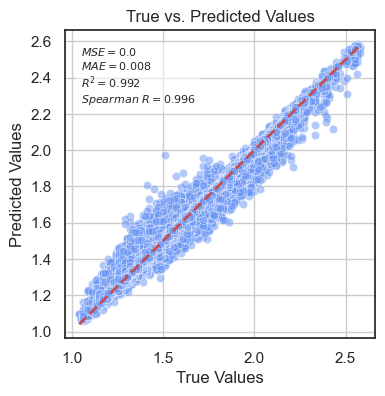

Evaluate on Test Set


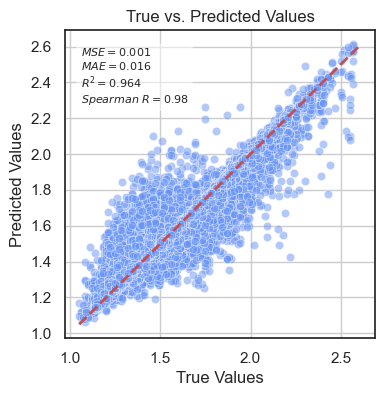

In [4]:
# Evaluate model on train and test set
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_train, y_train, dataset="Training", plot=True)
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_test, y_test, dataset="Test", plot=True)

**Model Interpretation**

Interpretation on Training Set

In [5]:
file_shap = f"../results/xgb/train_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_train = pickle.load(handle)

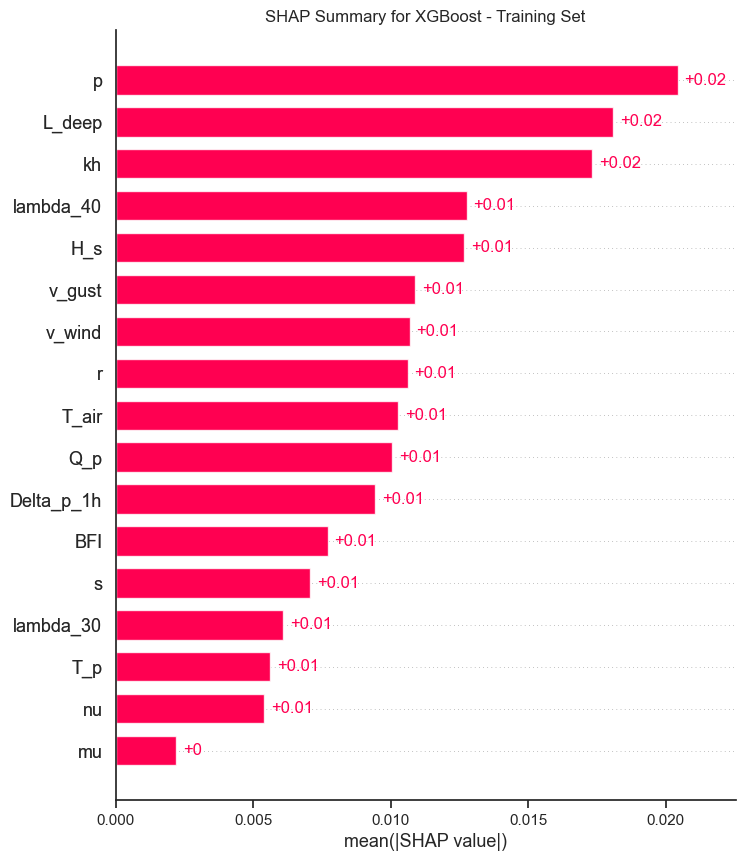

In [6]:
shap.plots.bar(explanation_train, max_display=17, show=False)
plt.title("SHAP Summary for XGBoost - Training Set")
plt.show()

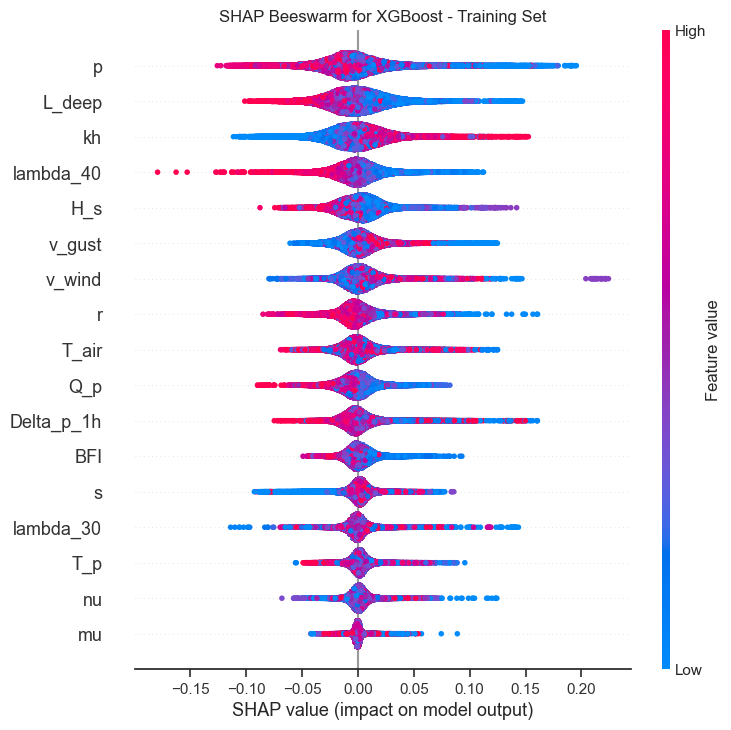

In [7]:
shap.plots.beeswarm(explanation_train, max_display=17, show=False)
plt.title("SHAP Beeswarm for XGBoost - Training Set")
plt.show()

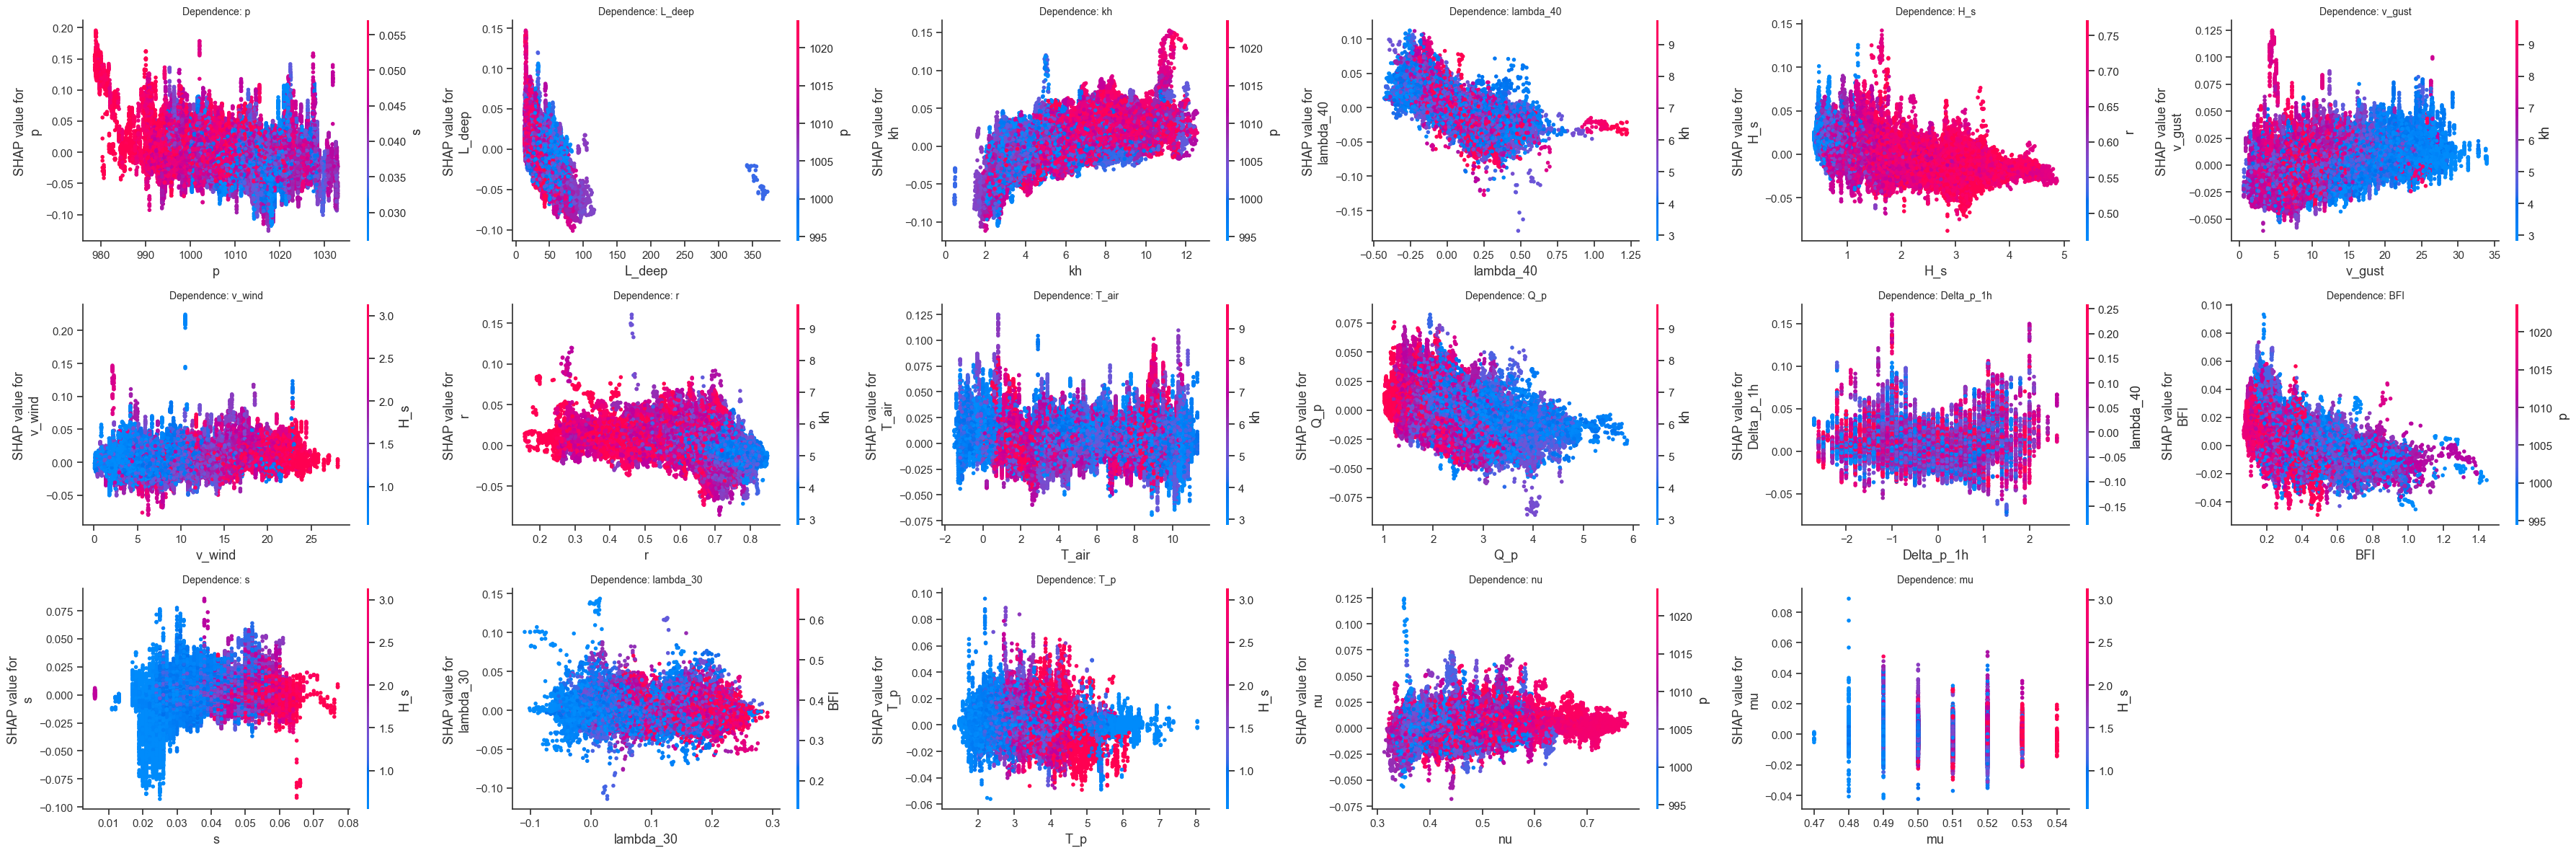

In [8]:
utils.plot_shap_dependence(explanation_train)

Interpretation on Test Set

In [9]:
file_shap = f"../results/xgb/test_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_test = pickle.load(handle)

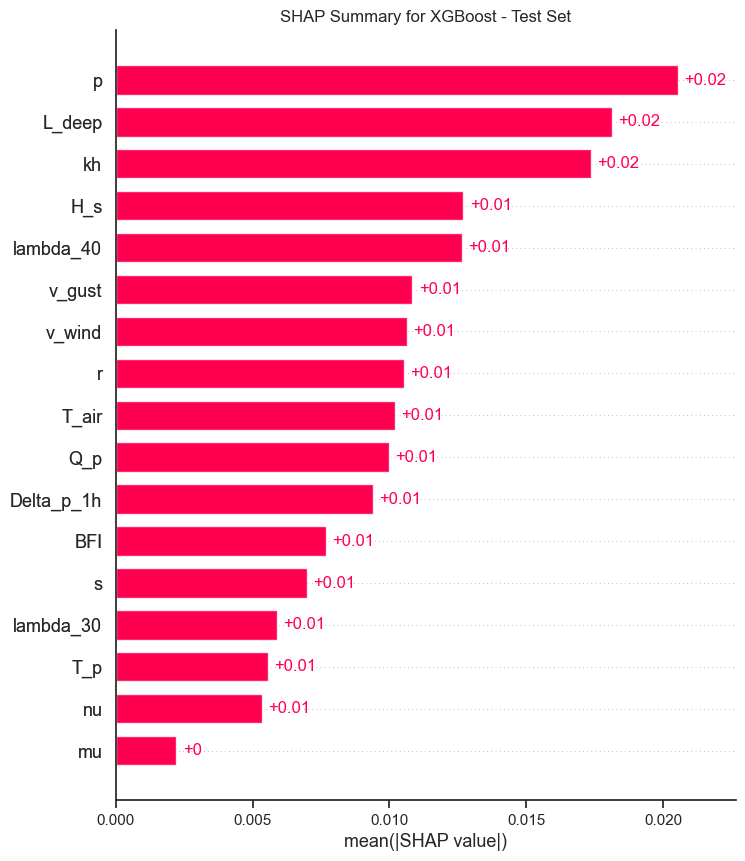

In [10]:
shap.plots.bar(explanation_test, max_display=17, show=False)
plt.title("SHAP Summary for XGBoost - Test Set")
plt.show()

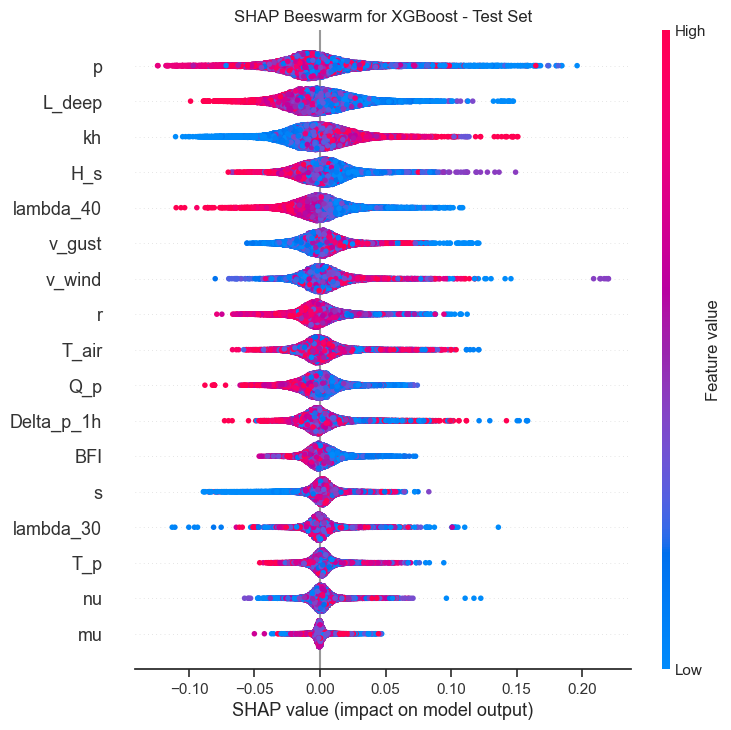

In [11]:
shap.plots.beeswarm(explanation_test, max_display=17, show=False)
plt.title("SHAP Beeswarm for XGBoost - Test Set")
plt.show()

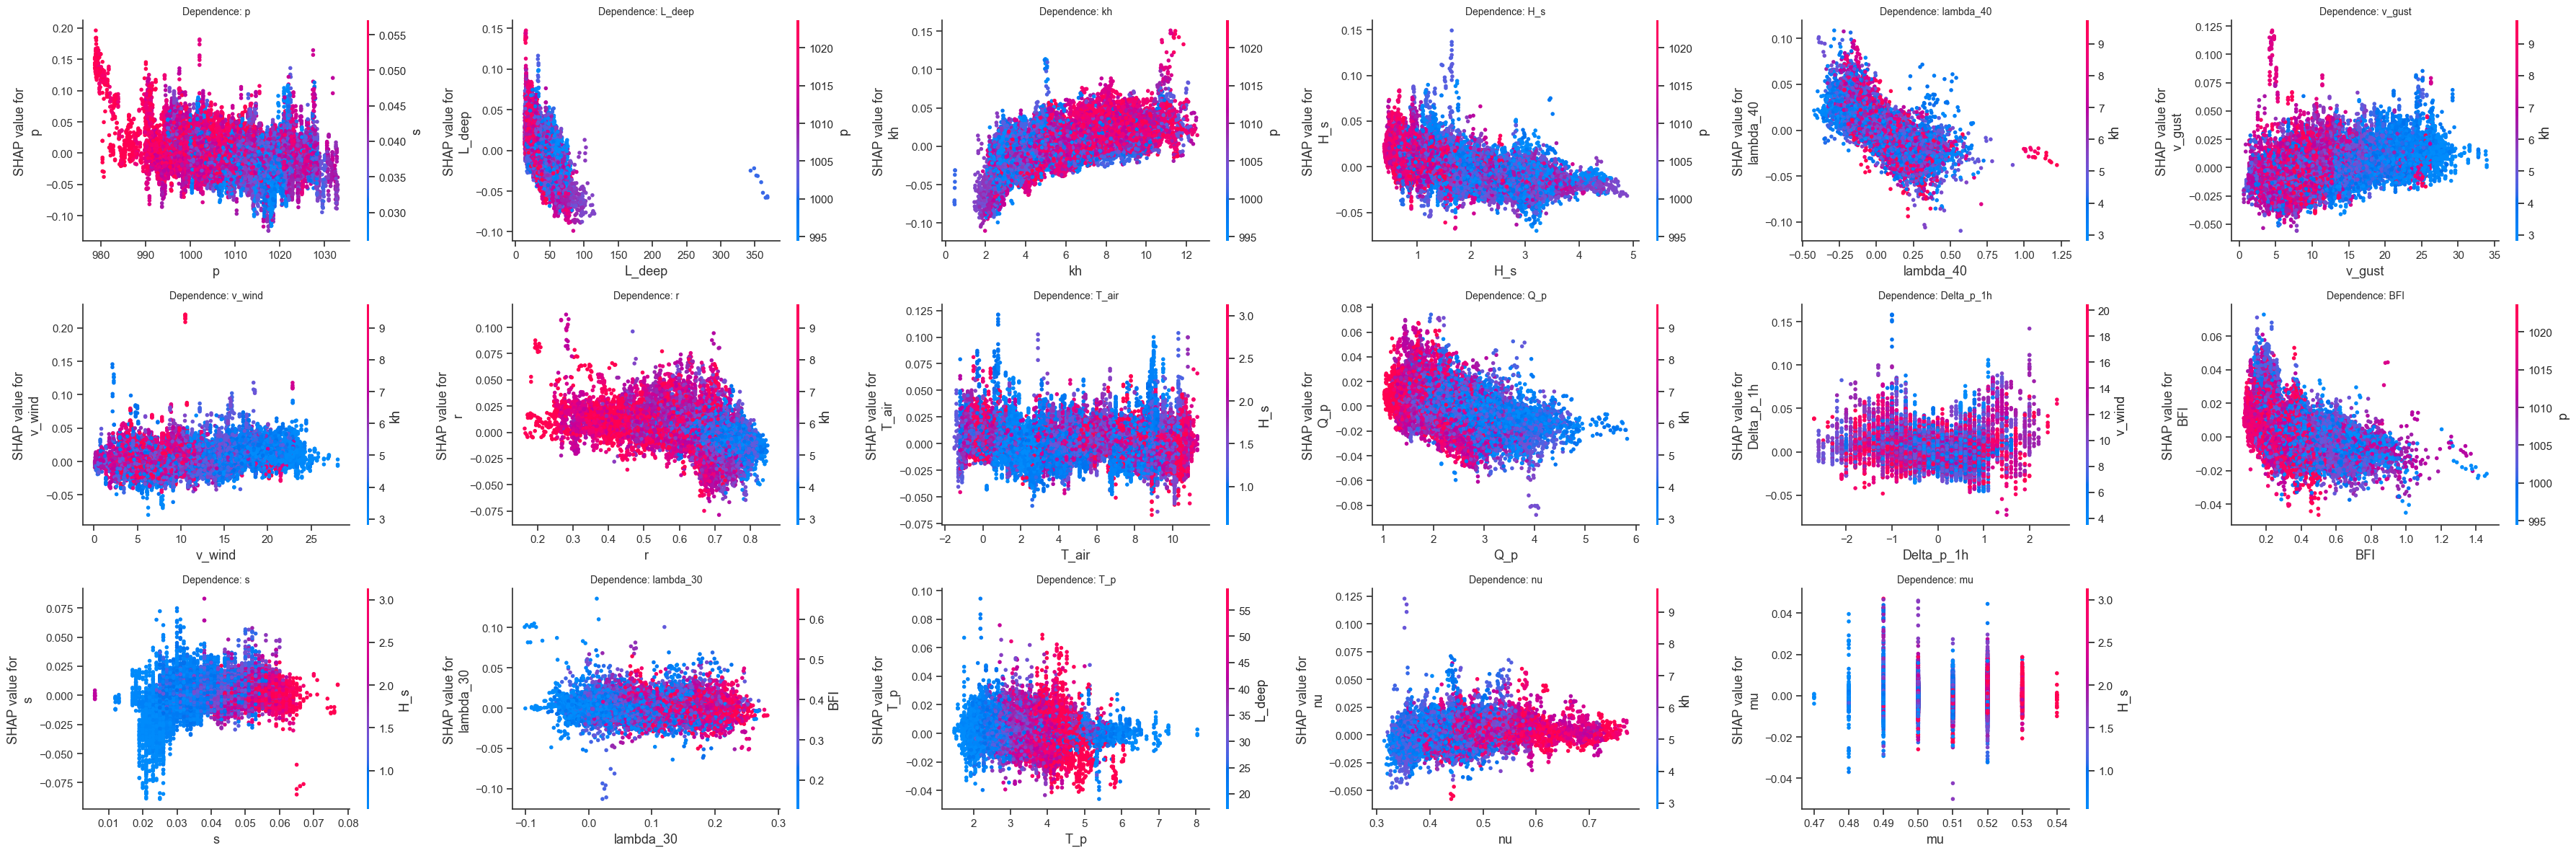

In [12]:
utils.plot_shap_dependence(explanation_test)